In [0]:
#!pip install pysurvival &> /dev/null

In [0]:
!curl -Lo m4.pkl https://manu00.s3-us-west-2.amazonaws.com/m4.pkl &> /dev/null

In [3]:
#### 1 - Importing packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pysurvival.models.simulations import SimulationModel
from pysurvival.models.parametric import GompertzModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
# Building training and testing sets
from sklearn.model_selection import train_test_split
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
# Reading the dataset
raw_dataset = pd.read_pickle("m4.pkl")

In [5]:
raw_dataset.columns

Index(['PolicyNumber', 'CoverageNumber', 'IssueAge', 'PolicyYear',
       'AttainedAge', 'IssueDate', 'MaturityDate', 'FaceAmount',
       'SmokerStatus', 'Gender', 'OccupationClass', 'CurrentProvince',
       'COLAIndicator', 'benefitPeriod', 'benefitPeriod_grouped',
       'benefitExpiryDate', 'DisabilityDuration', 'disabilityAge',
       'DisabilityReason', 'productDesign', 'EliminationPeriod',
       'EliminationPeriod_grouped', 'policyStartDate', 'policyEndDate',
       'exposureStartDate', 'exposureEndDate', 'TerminationEvent',
       'terminationReason', 'train'],
      dtype='object')

In [6]:
raw_dataset.head()

,PolicyNumber,CoverageNumber,IssueAge,PolicyYear,AttainedAge,IssueDate,MaturityDate,FaceAmount,SmokerStatus,Gender,OccupationClass,CurrentProvince,COLAIndicator,benefitPeriod,benefitPeriod_grouped,benefitExpiryDate,DisabilityDuration,disabilityAge,DisabilityReason,productDesign,EliminationPeriod,EliminationPeriod_grouped,policyStartDate,policyEndDate,exposureStartDate,exposureEndDate,TerminationEvent,terminationReason,train
0,H 0826898,2,23,21,43,1990-05-08,2010-05-31,100.0,N,M,2A,NS,0,2 years,Short-Term,2012-04-14,6,56,Other cancer,IncomeReplacement,120,120+,2010-05-08,2011-05-07,2010-05-16,2010-06-15,1,Death,1
1,H 0828055,1,21,41,61,1976-10-15,2021-01-15,200.0,N,M,A,QC,0,2 years,Short-Term,2018-08-23,5,60,Other accident/poisonings,IncomeReplacement,7,00-30,2016-10-15,2017-10-14,2016-11-25,2016-12-24,0,None,0
2,H 0833653,1,35,30,64,1978-12-01,2009-04-01,200.0,N,M,3A,NS,0,To age 65,ToAge65,2009-03-29,5,63,Other genitourinary/reproductive disorders,IncomeReplacement,90,90,2007-12-01,2008-11-30,2008-05-26,2008-06-25,1,Other,1
3,H 0834890,1,30,30,59,1979-05-20,2014-08-20,725.0,N,M,2A,AB,0,5 years,Short-Term,2008-08-28,64,53,Other musculoskeletal disorders,IncomeReplacement,120,120+,2008-05-20,2009-05-19,2008-08-01,2008-08-31,0,None,1
4,H 0840908,1,28,33,60,1981-11-03,2018-05-03,500.0,N,M,A,QC,0,2 years,Short-Term,2015-10-16,4,60,Other musculoskeletal disorders,IncomeReplacement,30,00-30,2013-11-03,2014-11-02,2013-12-17,2014-01-16,1,Other,1


In [7]:
raw_dataset.benefitPeriod.unique()

array(['2 years', 'To age 65', '5 years', 'Lifetime/To age 101',
       '18 months', '10 years', '1 year', '3 years', '4 months',
       'Not covered', '15 months'], dtype=object)

In [0]:
def time_remaining(row):
  remaining = np.nan
  if row['benefitPeriod']=='2 years':
    remaining = 24 - row['DisabilityDuration']
  if row['benefitPeriod']=='To age 65':
    remaining = 12*65 - row['disabilityAge'] - row['DisabilityDuration']
  if row['benefitPeriod']=='Lifetime/To age 101':
    remaining = 12*101 - row['disabilityAge'] - row['DisabilityDuration']
  if row['benefitPeriod']=='5 years':
    remaining = 60 - row['DisabilityDuration']
  if row['benefitPeriod']=='18 months':
    remaining = 18 - row['DisabilityDuration']
  if row['benefitPeriod']=='10 years':
    remaining = 120 - row['DisabilityDuration']
  if row['benefitPeriod']=='1 year':
    remaining = 12 - row['DisabilityDuration']
  if row['benefitPeriod']=='3 years':
    remaining = 36 - row['DisabilityDuration']
  if row['benefitPeriod']=='4 months':
    remaining = 4 - row['DisabilityDuration']
  if row['benefitPeriod']=='Not covered':
    remaining = 0
  if row['benefitPeriod']=='15 months':
    remaining = 15 - row['DisabilityDuration']
  return remaining


In [0]:
raw_dataset["remaining_months"] = raw_dataset.apply(time_remaining, axis=1)

In [0]:
raw_dataset['CurrentAge'] = raw_dataset['disabilityAge'] + raw_dataset['DisabilityDuration']/12.0

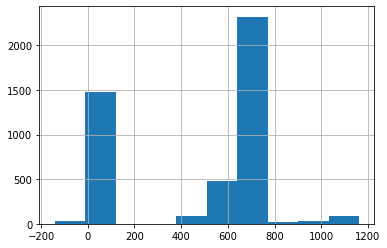

In [11]:
raw_dataset.remaining_months.hist()

In [0]:
#feature ideas
# benefit period in yrs
# elimination period in months?

In [0]:
to_drop = ['IssueDate', 'IssueAge','AttainedAge', 'MaturityDate', 'benefitExpiryDate', 'policyStartDate', 'policyEndDate',
           'exposureStartDate', 'exposureEndDate','terminationReason']
           
raw_dataset.drop(columns=to_drop,inplace=True)

In [14]:
raw_dataset.columns

Index(['PolicyNumber', 'CoverageNumber', 'PolicyYear', 'FaceAmount',
       'SmokerStatus', 'Gender', 'OccupationClass', 'CurrentProvince',
       'COLAIndicator', 'benefitPeriod', 'benefitPeriod_grouped',
       'DisabilityDuration', 'disabilityAge', 'DisabilityReason',
       'productDesign', 'EliminationPeriod', 'EliminationPeriod_grouped',
       'TerminationEvent', 'train', 'remaining_months', 'CurrentAge'],
      dtype='object')

In [0]:
categories = ['SmokerStatus', 'Gender', 'OccupationClass', 'CurrentProvince','COLAIndicator', 'benefitPeriod',
              'benefitPeriod_grouped','DisabilityReason', 'productDesign', 'EliminationPeriod', 
              'EliminationPeriod_grouped']
dataset = pd.get_dummies(raw_dataset, columns=categories, drop_first=True)    


In [0]:
train_data = dataset[dataset.train==1].reset_index(drop=True)
pred_data = dataset[dataset.train==0].reset_index(drop=True)

In [0]:
train_data.drop(columns=['train'], inplace=True)

In [18]:
dataset.shape # (4539, 127)
train_data.shape #(3348, 127)

(3348, 112)

In [0]:
# Creating the time and event columns
time_column = 'DisabilityDuration'
event_column = 'TerminationEvent'

# Extracting the features
features = np.setdiff1d(train_data.columns, [time_column, event_column,'PolicyNumber'] ).tolist()

In [20]:
%%time
# Checking for null values
N_null = sum(train_data[features].isnull().sum())
print("The train_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(train_data.duplicated(keep='first'))
train_data = train_data.drop_duplicates(keep='first').reset_index(drop=True)
print("The train_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = train_data.shape[0]

The train_dataset contains 0 null values
The train_dataset contains 0 duplicates
CPU times: user 59.4 ms, sys: 1.11 ms, total: 60.5 ms
Wall time: 63 ms


In [21]:
train_data.shape

(3348, 112)

In [0]:
# 75-25 train test split & stratify on event column
X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(train_data[features],train_data[time_column], train_data[event_column],test_size = 0.25, random_state=12345, stratify=train_data[event_column])

In [23]:
X_train.shape

(2511, 109)

In [24]:
X_test.head()

,COLAIndicator_1,CoverageNumber,CurrentAge,CurrentProvince_BC,CurrentProvince_MB,CurrentProvince_NB,CurrentProvince_NF,CurrentProvince_NS,CurrentProvince_ON,CurrentProvince_Outside Canada,CurrentProvince_PE,CurrentProvince_QC,CurrentProvince_SK,CurrentProvince_YT,DisabilityReason_Accidents/ poisoning/ violence,DisabilityReason_Allergic/ endocrine/ metabolic/ nutritional,DisabilityReason_Alzheimer's,DisabilityReason_Aneurysm/cerebral vascular accident,DisabilityReason_Arthritis,DisabilityReason_Asthma,DisabilityReason_Auto accident/MVA,DisabilityReason_Bi-polar/manic,DisabilityReason_Bowel cancer,DisabilityReason_Breast cancer,DisabilityReason_Carpal tunnel syndrome,DisabilityReason_Chemical sensitivity/environmental illness,DisabilityReason_Cholecystitis/gallstones,DisabilityReason_Chronic obstructive pulmonary/lung disorders,DisabilityReason_Chronic pain/fatigue syndrome,DisabilityReason_Congenital malformations,DisabilityReason_Congestive heart failure/CHF,DisabilityReason_Connective tissue disorders/lupus erythematosus,DisabilityReason_Coronary artery disease/By-pass,DisabilityReason_Crohn's disease/irritable bowel,DisabilityReason_Degenerative disc disease,DisabilityReason_Diabetes,DisabilityReason_Diseases of the bones and organs of movement,DisabilityReason_Diseases of the skin and cellular system,DisabilityReason_Fibromyalgia,DisabilityReason_Headaches/migraines,...,EliminationPeriod_15,EliminationPeriod_180,EliminationPeriod_30,EliminationPeriod_365,EliminationPeriod_60,EliminationPeriod_7,EliminationPeriod_730,EliminationPeriod_90,EliminationPeriod_grouped_120+,EliminationPeriod_grouped_60,EliminationPeriod_grouped_90,FaceAmount,Gender_M,OccupationClass_3A,OccupationClass_4A,OccupationClass_4S,OccupationClass_A,OccupationClass_B,PolicyYear,SmokerStatus_S,benefitPeriod_10 years,benefitPeriod_15 months,benefitPeriod_18 months,benefitPeriod_2 years,benefitPeriod_3 years,benefitPeriod_4 months,benefitPeriod_5 years,benefitPeriod_Lifetime/To age 101,benefitPeriod_Not covered,benefitPeriod_To age 65,benefitPeriod_grouped_Short-Term,benefitPeriod_grouped_ToAge65,disabilityAge,productDesign_ExpCompResidual,productDesign_ExpCompTotal,productDesign_IncomeReplacement,productDesign_Proguard,productDesign_Venture_ParRes,productDesign_Venture_Total,remaining_months
1728,0,1,62.083333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1300.0,1,1,0,0,0,0,25,1,0,0,0,1,0,0,0,0,0,0,1,0,60,0,0,1,0,0,0,-1
2741,0,1,64.666667,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,1,1000.0,1,0,0,0,1,0,16,0,0,0,0,0,0,0,0,0,0,1,0,1,59,0,0,0,0,1,0,653
2120,0,1,53.500000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,3224.0,0,1,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,1,0,1,53,0,0,0,0,0,1,721
1071,0,1,52.333333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,1,800.0,1,1,0,0,0,0,23,1,0,0,0,1,0,0,0,0,0,0,1,0,50,0,0,0,1,0,0,-4
2709,0,1,60.333333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,600.0,1,0,0,0,1,0,31,0,0,0,0,1,0,0,0,0,0,0,1,0,60,0,0,1,0,0,0,20


In [25]:
%%time
##6
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel

# Fitting the model
csf = ConditionalSurvivalForestModel(num_trees=200)
csf.fit(X_train, T_train, E_train, max_features='sqrt',
        max_depth=5, min_node_size=20, alpha=0.05, minprop=0.1) #0.74

CPU times: user 5min 52s, sys: 223 ms, total: 5min 52s
Wall time: 2min 59s


In [26]:
# Computing variables importance
csf.variable_importance_table.head(10)

,feature,importance,pct_importance
0,CurrentAge,9.985742,0.110013
1,remaining_months,9.206785,0.101431
2,PolicyYear,6.011262,0.066226
3,EliminationPeriod_grouped_120+,5.009905,0.055194
4,EliminationPeriod_120,4.788361,0.052753
5,productDesign_IncomeReplacement,4.494399,0.049515
6,disabilityAge,4.109956,0.045279
7,benefitPeriod_To age 65,3.812906,0.042007
8,FaceAmount,3.228864,0.035572
9,productDesign_Venture_Total,3.108372,0.034245


In [27]:
#cross validation
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(csf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index)) #0.75

C-index: 0.70


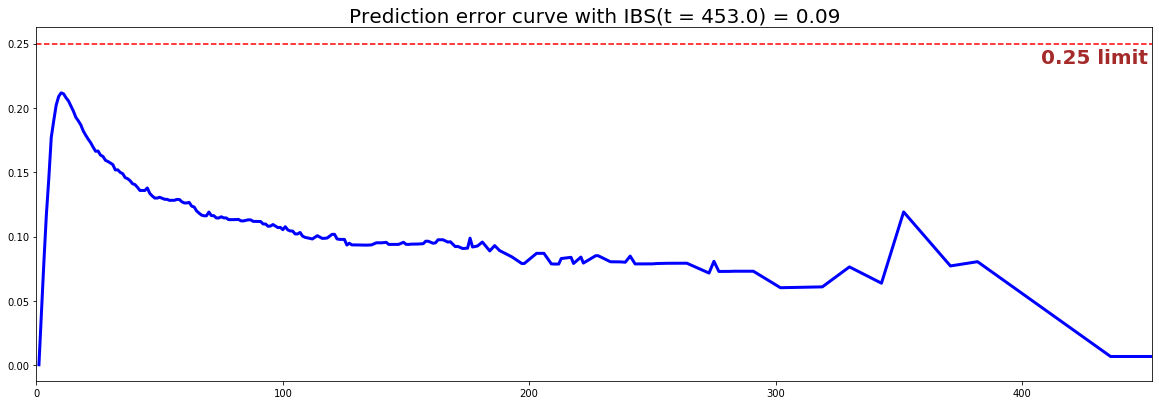

IBS: 0.09


In [28]:
ibs = integrated_brier_score(csf, X_test, T_test, E_test, t_max=600,
            figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

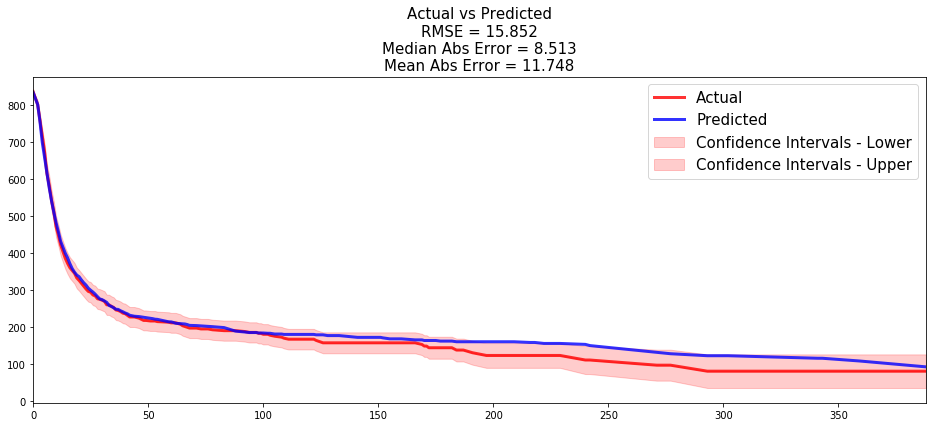

In [29]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(csf, X_test, T_test, E_test,
                            is_at_risk = True,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

In [30]:
k = 20
predicted = csf.predict_survival(X_test.values[k, :], t=T_test.iloc[k]).flatten()
print(X_test.values[k, :])
print(T_test.iloc[k])
print(predicted)
print(E_test.iloc[k])

[0.00000000e+00 1.00000000e+00 5.21666667e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [0]:
#test set survival function -  probability that the event of interest has not occurred by some time 
p = []
for i in range(len(X_test)):
    p.extend(csf.predict_survival(X_test.values[i, :], t=T_test.iloc[i]).flatten())

In [0]:
X_test["survival_function"] = pd.DataFrame(p)

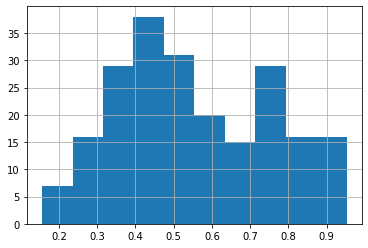

In [33]:
X_test.survival_function.hist()

In [0]:
pred_data['CurrentAge'] = pred_data["CurrentAge"].apply(lambda x: x+1)
pred_data['DisabilityDuration'] = pred_data["DisabilityDuration"].apply(lambda x: x+12)
pred_data['DisabilityDuration'] = pred_data["DisabilityDuration"].apply(lambda x: x-12)

In [0]:
X_pred, T_pred = pred_data[features],pred_data[time_column]

In [36]:
p = []
for i in range(len(X_pred)):
    p.extend(csf.predict_survival(X_pred.values[i, :], t=T_pred.iloc[i]).flatten())
X_pred["survival_function"] = pd.DataFrame(p)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


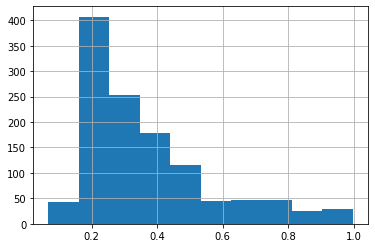

In [37]:
X_pred.survival_function.hist()

In [38]:
X_pred.head()

,COLAIndicator_1,CoverageNumber,CurrentAge,CurrentProvince_BC,CurrentProvince_MB,CurrentProvince_NB,CurrentProvince_NF,CurrentProvince_NS,CurrentProvince_ON,CurrentProvince_Outside Canada,CurrentProvince_PE,CurrentProvince_QC,CurrentProvince_SK,CurrentProvince_YT,DisabilityReason_Accidents/ poisoning/ violence,DisabilityReason_Allergic/ endocrine/ metabolic/ nutritional,DisabilityReason_Alzheimer's,DisabilityReason_Aneurysm/cerebral vascular accident,DisabilityReason_Arthritis,DisabilityReason_Asthma,DisabilityReason_Auto accident/MVA,DisabilityReason_Bi-polar/manic,DisabilityReason_Bowel cancer,DisabilityReason_Breast cancer,DisabilityReason_Carpal tunnel syndrome,DisabilityReason_Chemical sensitivity/environmental illness,DisabilityReason_Cholecystitis/gallstones,DisabilityReason_Chronic obstructive pulmonary/lung disorders,DisabilityReason_Chronic pain/fatigue syndrome,DisabilityReason_Congenital malformations,DisabilityReason_Congestive heart failure/CHF,DisabilityReason_Connective tissue disorders/lupus erythematosus,DisabilityReason_Coronary artery disease/By-pass,DisabilityReason_Crohn's disease/irritable bowel,DisabilityReason_Degenerative disc disease,DisabilityReason_Diabetes,DisabilityReason_Diseases of the bones and organs of movement,DisabilityReason_Diseases of the skin and cellular system,DisabilityReason_Fibromyalgia,DisabilityReason_Headaches/migraines,...,EliminationPeriod_180,EliminationPeriod_30,EliminationPeriod_365,EliminationPeriod_60,EliminationPeriod_7,EliminationPeriod_730,EliminationPeriod_90,EliminationPeriod_grouped_120+,EliminationPeriod_grouped_60,EliminationPeriod_grouped_90,FaceAmount,Gender_M,OccupationClass_3A,OccupationClass_4A,OccupationClass_4S,OccupationClass_A,OccupationClass_B,PolicyYear,SmokerStatus_S,benefitPeriod_10 years,benefitPeriod_15 months,benefitPeriod_18 months,benefitPeriod_2 years,benefitPeriod_3 years,benefitPeriod_4 months,benefitPeriod_5 years,benefitPeriod_Lifetime/To age 101,benefitPeriod_Not covered,benefitPeriod_To age 65,benefitPeriod_grouped_Short-Term,benefitPeriod_grouped_ToAge65,disabilityAge,productDesign_ExpCompResidual,productDesign_ExpCompTotal,productDesign_IncomeReplacement,productDesign_Proguard,productDesign_Venture_ParRes,productDesign_Venture_Total,remaining_months,survival_function
0,0,1,61.416667,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,200.0,1,0,0,0,1,0,41,0,0,0,0,1,0,0,0,0,0,0,1,0,60,0,0,1,0,0,0,19,0.741118
1,1,1,62.916667,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1000.0,1,1,0,0,0,0,33,0,0,0,0,0,0,0,0,1,0,0,0,0,57,0,0,0,1,0,0,1096,0.220813
2,1,3,62.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1,550.0,1,0,1,0,0,0,25,0,0,0,0,0,0,0,0,0,0,1,0,1,55,0,0,0,1,0,0,649,0.235137
3,0,1,65.166667,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,3675.0,0,0,1,0,0,0,24,1,0,0,0,0,0,0,0,0,0,1,0,1,42,0,0,0,1,0,0,472,0.316915
4,0,1,56.583333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1,2058.0,1,0,0,0,1,0,23,0,1,0,0,0,0,0,0,0,0,0,1,0,55,0,0,0,0,0,1,113,0.676649


In [39]:
pred_data["survival_function"] = pd.DataFrame(p)
pred_data.head()

,PolicyNumber,CoverageNumber,PolicyYear,FaceAmount,DisabilityDuration,disabilityAge,TerminationEvent,train,remaining_months,CurrentAge,SmokerStatus_S,Gender_M,OccupationClass_3A,OccupationClass_4A,OccupationClass_4S,OccupationClass_A,OccupationClass_B,CurrentProvince_BC,CurrentProvince_MB,CurrentProvince_NB,CurrentProvince_NF,CurrentProvince_NS,CurrentProvince_ON,CurrentProvince_Outside Canada,CurrentProvince_PE,CurrentProvince_QC,CurrentProvince_SK,CurrentProvince_YT,COLAIndicator_1,benefitPeriod_10 years,benefitPeriod_15 months,benefitPeriod_18 months,benefitPeriod_2 years,benefitPeriod_3 years,benefitPeriod_4 months,benefitPeriod_5 years,benefitPeriod_Lifetime/To age 101,benefitPeriod_Not covered,benefitPeriod_To age 65,benefitPeriod_grouped_Short-Term,...,DisabilityReason_Myocardial infarction/MI,DisabilityReason_Other accident/poisonings,DisabilityReason_Other allergic and endocrine disorders,DisabilityReason_Other bacterial/viral/fungal,DisabilityReason_Other cancer,DisabilityReason_Other central nervous system and sense organs,DisabilityReason_Other disorders of blood/blood immune mechanism,DisabilityReason_Other functional somatic syndromes,DisabilityReason_Other genitourinary/reproductive disorders,DisabilityReason_Other heart and circulatory system disorders,DisabilityReason_Other musculoskeletal disorders,DisabilityReason_Other nervous and mental,DisabilityReason_Other oral cavity and digestive system disorders,DisabilityReason_Other respiratory system disorders,DisabilityReason_Other unspecified neoplasms (benign),DisabilityReason_Ovarian cyst,DisabilityReason_Pregnancy including complications,DisabilityReason_Substance abuse/alcoholism,DisabilityReason_Systemic lupus,DisabilityReason_Work related accident,productDesign_ExpCompResidual,productDesign_ExpCompTotal,productDesign_IncomeReplacement,productDesign_Proguard,productDesign_Venture_ParRes,productDesign_Venture_Total,EliminationPeriod_7,EliminationPeriod_14,EliminationPeriod_15,EliminationPeriod_30,EliminationPeriod_60,EliminationPeriod_90,EliminationPeriod_120,EliminationPeriod_180,EliminationPeriod_365,EliminationPeriod_730,EliminationPeriod_grouped_120+,EliminationPeriod_grouped_60,EliminationPeriod_grouped_90,survival_function
0,H 0828055,1,41,200.0,5,60,0,0,19,61.416667,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.741118
1,H 0852059,1,33,1000.0,59,57,0,0,1096,62.916667,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.220813
2,H 0865986,3,25,550.0,76,55,0,0,649,62.333333,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.235137
3,H 0935503,1,24,3675.0,266,42,0,0,472,65.166667,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.316915
4,H 0942758,1,23,2058.0,7,55,0,0,113,56.583333,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0.676649


In [0]:
pred_data[['PolicyNumber','CoverageNumber','survival_function']].to_csv("ConditionalSurvivalForestModel.csv",index=False)